<a href="https://colab.research.google.com/github/riddhiman-ghatak/image_colorization_using-GAN/blob/main/image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)


In [2]:
batch_size = 64
img_size = 120
dataset_split = 2500


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/data-20221105T072434Z-001.zip

Archive:  /content/drive/MyDrive/data-20221105T072434Z-001.zip
  inflating: data/24319.jpg          
  inflating: data/24320.jpg          
  inflating: data/24297.jpg          
  inflating: data/24325.jpg          
  inflating: data/24321.jpg          
  inflating: data/24313.jpg          
  inflating: data/24324.jpg          
  inflating: data/24287.jpg          
  inflating: data/24315.jpg          
  inflating: data/24310.jpg          
  inflating: data/24304.jpg          
  inflating: data/24328.jpg          
  inflating: data/24311.jpg          
  inflating: data/24334.jpg          
  inflating: data/24294.jpg          
  inflating: data/24295.jpg          
  inflating: data/24269.jpg          
  inflating: data/24309.jpg          
  inflating: data/24279.jpg          
  inflating: data/24290.jpg          
  inflating: data/24282.jpg          
  inflating: data/24329.jpg          
  inflating: data/24323.jpg          
  inflating: data/24274.jpg          
  inflating: data/24268.j

In [5]:
master_dir = 'data'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

In [6]:
x = np.array(x)
y = np.array(y)

In [7]:
train_x, test_x, train_y, test_y = train_test_split( x , y , test_size=0.1 )
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )


In [8]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model

In [9]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


In [11]:
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)


In [12]:
num_epochs = 20
losses = {"D":[], "G":[]}
for e in range( num_epochs ):
    print("Running epoch : ", e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        # print( x.shape )
        train_step( x , y )

Running epoch :  0
Running epoch :  1
Running epoch :  2
Running epoch :  3
Running epoch :  4
Running epoch :  5
Running epoch :  6
Running epoch :  7
Running epoch :  8
Running epoch :  9
Running epoch :  10
Running epoch :  11
Running epoch :  12
Running epoch :  13
Running epoch :  14
Running epoch :  15
Running epoch :  16
Running epoch :  17
Running epoch :  18
Running epoch :  19


In [17]:
generator.save("./TSR.h5")

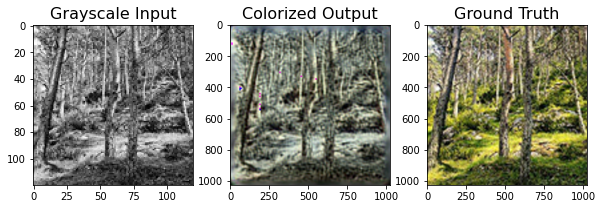

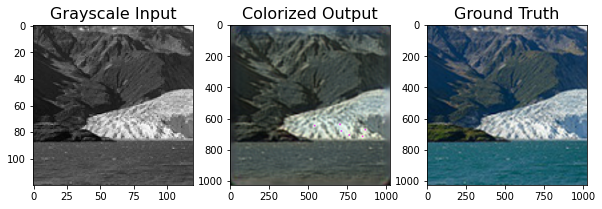

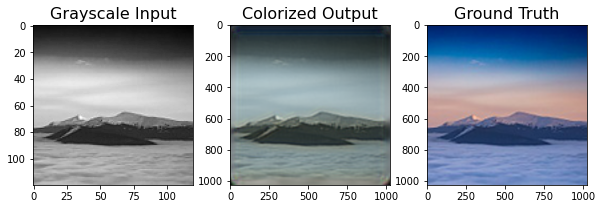

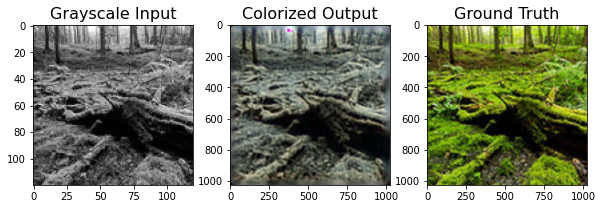

In [18]:
y = generator( test_x[0 : ] ).numpy()
for i in range(11, 33, 7):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()